--------
TASK 2 (ML eng. only)
--------

Imagine the digits in the test set of the MNIST dataset
(http://yann.lecun.com/exdb/mnist/) got cut in half vertically and shuffled
around. Implement a way to restore the original test set from the two halves,
whilst maximising the overall matching accuracy.

## 1. Generate Data

In [1]:
import os

import matplotlib.pyplot as plt
import scipy.spatial as sp
import torch
import torch.nn as nn
import torchvision
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import typing
os.environ['KMP_DUPLICATE_LIB_OK']='True'



#### Implems

from src.eval import custom_matching_score, generate_y_pred
from src.model.cosine_sim_affinity_matrix import generate_affinity_matrix
from src.model.generate_pairs import create_pairs_affinity_matrix
from src.model.similairty_siamese_network import SiameseNetwork, SiameseNetworkDataset, \
    generate_affinity_matrix_deep_learning
from src.utils import split_left_right

In [2]:
def generate_task_data(data: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    
    size_data = data.shape[0]
    data_split = data.data.unfold(2,14,14)
    X = torch.concat((data_split[:,:,0,:], data_split[:,:,1,:]))
    y = torch.concat((torch.arange(size_data), torch.arange(size_data)))
    return X, y 

mnist_data_train = torchvision.datasets.MNIST('data_root', train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST('data_root', train=False, download=True)
                  
X_train, y_train = generate_task_data(mnist_data_train.data)
original_target_train = torch.concat((mnist_data_train.targets, mnist_data_train.targets))
X_test, y_test = generate_task_data(mnist_data_test.data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data_root/MNIST/raw/train-images-idx3-ubyte.gz to data_root/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data_root/MNIST/raw/train-labels-idx1-ubyte.gz to data_root/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data_root/MNIST/raw/t10k-images-idx3-ubyte.gz to data_root/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_root/MNIST/raw



In [3]:
### shuffle test data
indices_shuffled = torch.randperm(X_test.shape[0])

X_test = X_test[indices_shuffled]
y_test = y_test[indices_shuffled]

# 2. Display images

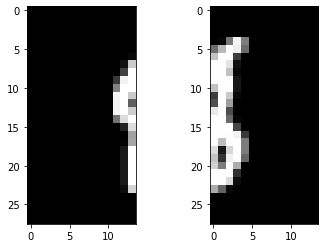

In [4]:
idx = 7308

tuple_ground_truth = (y_train == idx).nonzero(as_tuple=True)
idx_left, idx_right = tuple_ground_truth[0][0].item(), tuple_ground_truth[0][1].item()
img_left_side = X_train[idx_left,:,:]
img_right_side = X_train[idx_right,:,:]

f, axarr = plt.subplots(1,2)

axarr[0].imshow(img_left_side, cmap = plt.cm.gray)
axarr[1].imshow(img_right_side, cmap = plt.cm.gray)

plt.show()

# Unsupervised similarity based solution

First idea I had while watching the challenge is that:
1. We can easily split the images into left and right halves because the mnist numbers are centered, so we always have non-zero pixels in the middle of the image (meaning the left half will have more pixels at the top than right for example)
2. Normally as we have a continuity between the left half and the right half, I think that comparing the top right vector of the left images with the top left vector of the right images will make it possible to effectively make pairs
3. Doing one by one comparison allows to generate an affinity matrix
4. We can create pairs using the affinity matrix (using hungarian method)

An attention was given to code optimization because generating an affinity matrix is extremely costly

In [5]:
af, indices_left_test, indices_right_test = generate_affinity_matrix(X_test.data) ##split between left and right halves + use similarity between vector in order to generate an affinity matrix

assert(len(indices_left_test) == len(indices_right_test))

In [6]:
list_pairs = create_pairs_affinity_matrix(af, indices_left_test, indices_right_test)

In [7]:
y_pred = generate_y_pred(list_pairs)
ad_score = metrics.adjusted_rand_score(y_test, y_pred)
matching_score = custom_matching_score(list_pairs, y_test)


print("\n")
print("**Rule based unsupervised method**")
print(f"Adjusted rand score {ad_score}")
print(f"Matching score {matching_score}")

100%|██████████| 10000/10000 [00:00<00:00, 716730.01it/s]



**Rule based unsupervised method**
Adjusted rand score 0.082054100410041
Matching score 0.0821


# Siamese network based architecture

Instead of using an heuristic for affinity matrix generation we propose to use a siamese network trained to associate left halves to the correct right half

Inspired from this tutorial for fast implementation https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/

In [8]:

images_left_side, images_right_side, indices_left, indices_right = split_left_right(X_train)
y_train_left, y_train_right = y_train[indices_left], y_train[indices_right]
original_target_train_left, original_target_train_right = original_target_train[indices_left], original_target_train[indices_right]


images_left_side_train, images_left_side_val, images_right_side_train, \
images_right_side_val, y_train_left_train, y_train_left_val, \
y_train_right_train, y_train_right_val, original_target_left_train, \
original_target_left_val, original_target_right_train, original_target_right_val = train_test_split(images_left_side, \
                                                                                                    images_right_side, y_train_left, y_train_right, original_target_train_left, \
                                                                                                    original_target_train_right, test_size=0.01)

siamese_dataset_train = SiameseNetworkDataset(images_left_side_train, images_right_side_train, y_train_left_train, y_train_right_train, original_target_left_train, original_target_right_train)
siamese_dataset_val = SiameseNetworkDataset(images_left_side_val, images_right_side_val, y_train_left_val, y_train_right_val, original_target_left_val, original_target_right_val)

## Network trained only on the similarity task

In [22]:
from torch import optim
from torch import nn
from torch.utils.data.dataloader import default_collate

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # or whatever device/cpu you like
else:
    device = torch.device('cpu')

counter = []
loss_history = [] 
iteration_number= 0

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1024, 
                        collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# Load the validation_set

val_dataloader = DataLoader(siamese_dataset_val,
                        shuffle=False,
                        num_workers=0,
                        batch_size=640,
                        collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

net_only_sim = SiameseNetwork().to(device)
criterion = nn.BCELoss().to(device)

optimizer = optim.Adam(net_only_sim.parameters(), lr = 0.0005 )
# Iterate throught the epochs
for epoch in range(250):
    net_only_sim = net_only_sim.train()
    # Iterate over batches
    for i, (img0, img1, label_sim, label_mnist_img1, label_mnist_img2) in enumerate(train_dataloader, 0):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, _, _ = net_only_sim(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1.view(-1), label_sim.float())

        loss_full = loss_contrastive
        # Calculate the backpropagation
        loss_full.backward()

        # Optimize
        optimizer.step()

        # Every 8 batches print out the loss
        if i % 8 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 8

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

    #eval validation

    with torch.no_grad():
        net_only_sim = net_only_sim.eval()
        sum_loss = 0
        sum_ok = 0
        for i, (img0, img1, label_sim, label_mnist_img1, label_mnist_img2) in enumerate(val_dataloader, 0):
            output, classif1, classif2 = net_only_sim(img0, img1)
            sum_loss += criterion(output.view(-1), label_sim.float()).item()
            sum_ok += torch.sum(output.flatten().round() == label_sim)

        print(f"Epoch number {epoch}\n Current val loss {sum_loss/len(val_dataloader.dataset)}\n")
        print(f"Epoch number {epoch}\n Current val accuracy {sum_ok/len(val_dataloader.dataset)}\n")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 Current loss 0.12364612519741058

Epoch number 83
 Current loss 0.09620368480682373

Epoch number 83
 Current loss 0.1356206238269806

Epoch number 83
 Current loss 0.1152065098285675

Epoch number 83
 Current loss 0.11840129643678665

Epoch number 83
 Current val loss 0.00022928841412067413

Epoch number 83
 Current val accuracy 0.9433333277702332

Epoch number 84
 Current loss 0.20422326028347015

Epoch number 84
 Current loss 0.21649715304374695

Epoch number 84
 Current loss 0.16757939755916595

Epoch number 84
 Current loss 0.13857747614383698

Epoch number 84
 Current loss 0.15492336452007294

Epoch number 84
 Current loss 0.12406666576862335

Epoch number 84
 Current loss 0.09018997848033905

Epoch number 84
 Current loss 0.1291504204273224

Epoch number 84
 Current val loss 0.0001596575230360031

Epoch number 84
 Current val accuracy 0.9733333587646484

Epoch number 85
 Current loss 0.129987150430679

In [23]:
print("Inference siamese network only sim") ##optimized cnn goes only once on each images
af_matrx_deep_learning_sim, indices_left_test_n, indices_right_test_n = generate_affinity_matrix_deep_learning(X_test, net_only_sim)

Inference siamese network only sim


100%|██████████| 10000/10000 [00:13<00:00, 751.96it/s]


In [24]:
list_pairs = create_pairs_affinity_matrix(af_matrx_deep_learning_sim.T, indices_left_test_n, indices_right_test_n)

In [25]:
y_pred = generate_y_pred(list_pairs)
ad_score = metrics.adjusted_rand_score(y_test, y_pred)
matching_score = custom_matching_score(list_pairs, y_test)

print("\n")
print("**Siamese network solution trained only with sim loss**")
print(f"Adjusted rand score {ad_score}")
print(f"Matching score {matching_score}")

100%|██████████| 10000/10000 [00:00<00:00, 959641.25it/s]



**Siamese network solution trained only with sim loss**
Adjusted rand score 0.10795539553955395
Matching score 0.108


## Network trained on similarity + classification task 

In [11]:
from torch import optim
from torch import nn
from torch.utils.data.dataloader import default_collate

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # or whatever device/cpu you like
else:
    device = torch.device('cpu')

counter = []
loss_history = [] 
iteration_number= 0

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=0,
                        batch_size=128, 
                        collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# Load the validation_set

val_dataloader = DataLoader(siamese_dataset_val,
                        shuffle=False,
                        num_workers=0,
                        batch_size=640,
                        collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

net = SiameseNetwork().to(device)
criterion = nn.BCELoss().to(device)

criterion_classif = nn.CrossEntropyLoss().to(device) 

optimizer = optim.Adam(net.parameters(), lr = 0.0005 )
# Iterate throught the epochs
for epoch in range(250):
    net = net.train()
    # Iterate over batches
    for i, (img0, img1, label_sim, label_mnist_img1, label_mnist_img2) in enumerate(train_dataloader, 0):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, classif1, classif2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1.view(-1), label_sim.float())
        loss_c_1 = criterion_classif(classif1, label_mnist_img1)
        loss_c_2 = criterion_classif(classif2, label_mnist_img2)

        loss_full = 2*loss_contrastive + loss_c_1 + loss_c_2
        # Calculate the backpropagation
        loss_full.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 200 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


    #eval validation

    with torch.no_grad():
        net = net.eval()
        sum_loss = 0
        sum_ok = 0
        for i, (img0, img1, label_sim, label_mnist_img1, label_mnist_img2) in enumerate(val_dataloader, 0):
            output, classif1, classif2 = net(img0, img1)
            sum_loss += criterion(output.view(-1), label_sim.float()).item()
            sum_ok += torch.sum(output.flatten().round() == label_sim)

        print(f"Epoch number {epoch}\n Current val loss {sum_loss/len(val_dataloader.dataset)}\n")
        print(f"Epoch number {epoch}\n Current val accuracy {sum_ok/len(val_dataloader.dataset)}\n")

Epoch number 0
 Current loss 0.6993808746337891

Epoch number 0
 Current loss 0.4410718083381653

Epoch number 0
 Current loss 0.4879257082939148

Epoch number 0
 Current val loss 0.0005729622642199198

Epoch number 0
 Current val accuracy 0.8516666889190674

Epoch number 1
 Current loss 0.34115996956825256

Epoch number 1
 Current loss 0.39529988169670105

Epoch number 1
 Current loss 0.3076915740966797

Epoch number 1
 Current val loss 0.00039613751073678334

Epoch number 1
 Current val accuracy 0.9133333563804626

Epoch number 2
 Current loss 0.21442660689353943

Epoch number 2
 Current loss 0.1997888833284378

Epoch number 2
 Current loss 0.20868678390979767

Epoch number 2
 Current val loss 0.00029803872108459474

Epoch number 2
 Current val accuracy 0.9350000023841858

Epoch number 3
 Current loss 0.26439088582992554

Epoch number 3
 Current loss 0.2429509460926056

Epoch number 3
 Current loss 0.3146761357784271

Epoch number 3
 Current val loss 0.0003548849622408549

Epoch numb

In [12]:
print("Inference siamese network") ##optimized cnn goes only once on each images
af_matrx_deep_learning, indices_left_test_n, indices_right_test_n = generate_affinity_matrix_deep_learning(X_test, net)

Inference siamese network


100%|██████████| 10000/10000 [00:13<00:00, 751.59it/s]


In [13]:
list_pairs = create_pairs_affinity_matrix(af_matrx_deep_learning.T, indices_left_test_n, indices_right_test_n)

In [14]:
y_pred = generate_y_pred(list_pairs)
ad_score = metrics.adjusted_rand_score(y_test, y_pred)
matching_score = custom_matching_score(list_pairs, y_test)

print("\n")
print("**Siamese network solution**")
print(f"Adjusted rand score {ad_score}")
print(f"Matching score {matching_score}")

100%|██████████| 10000/10000 [00:00<00:00, 1208071.66it/s]



**Siamese network solution**
Adjusted rand score 0.10595529552955296
Matching score 0.106


# Combine solutions

In [15]:
assert (indices_left_test_n == indices_left_test).all() ##we cannot combine if indices are not the same between the two approaches
assert (indices_right_test_n == indices_right_test).all()

In [36]:
af_combined = af_matrx_deep_learning_sim.T + af_matrx_deep_learning.T + 0.5*af ## af_matrix_deep_learning_sim = affinity matrix generated based on a siamese network trained on the reconstruction task only
#af_matrx_deep_learning = affinity matrix generated based on a siamese network trained on classification of half images + on the reconstruction task
# af = affinity matrix generated using border vectors similarity (unsupervised)
list_pairs = create_pairs_affinity_matrix(af_combined, indices_left_test, indices_right_test)

In [37]:
y_pred = generate_y_pred(list_pairs)

ad_score = metrics.adjusted_rand_score(y_test, y_pred)
matching_score = custom_matching_score(list_pairs, y_test)

print("\n")
print("**Ensembling of my two affinity matrix solution**")
print(f"Adjusted rand score {ad_score}")
print(f"Matching score {matching_score}")

100%|██████████| 10000/10000 [00:00<00:00, 1260194.09it/s]



**Ensembling of my two affinity matrix solution**
Adjusted rand score 0.3588679417941794
Matching score 0.3589


# Error display

In [28]:
### Analyze some errors
list_errors = []

for pair in tqdm(list_pairs):
  if y_test[pair[0]] != y_test[pair[1]]:
    list_errors.append(pair)

100%|██████████| 10000/10000 [00:00<00:00, 143405.30it/s]


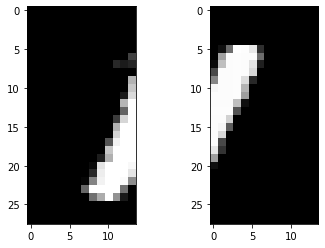

In [39]:
error_idx = 0

idx_left, idx_right = list_errors[error_idx]

img_left_side = X_test[idx_left,:,:]
img_right_side = X_test[idx_right,:,:]

f, axarr = plt.subplots(1,2)

axarr[0].imshow(img_left_side, cmap = plt.cm.gray)
axarr[1].imshow(img_right_side, cmap = plt.cm.gray)